# Southern Ocean Codes

In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore") 

import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

In [2]:
import numpy as np
import xesmf as xe
import xarray as xr
import seawater as sw

import copy

## Initialize Dataset

Read CMIP6 data from Google Cloud using intake

In [3]:
import intake
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
cat = intake.open_catalog(url)
col = cat.climate.cmip6_gcs()

In [4]:
def rename_coords(ds):
    ds = ds.copy()
    """Rename all depth dim to `lev`"""
    if "olevel" in ds.coords:
        ds = ds.rename({"olevel": "lev"})
    if "lev_partial" in ds.coords:
        ds = ds.rename({"lev_partial": "lev"})
    """Rename all latitude, longitude dim to `lat`,`lon`"""
    if 'latitude' in ds.coords:
        ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in ds.coords:
        ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    if 'nav_lat' in ds.coords:
        ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    """decode cftime"""
    ds = xr.decode_cf(ds)
    return ds

def func_get_data(col, model, var, expe, freq, mem = 'r1i1p1f1', grid = 'gr'):
    dcat = col.search(variable_id = var,
                      table_id = freq, 
                      experiment_id = expe,
                      source_id = model,
                      member_id = mem, 
                      grid_label = grid)
    if dcat.df.empty:
        print('No data')
    else:
        key0 = dcat.keys()[0]
        data_source = dcat[key0]
        z_kwargs = {'consolidated': True, 'decode_times':False}
        dataset = data_source(zarr_kwargs=z_kwargs, preprocess=rename_coords).to_dask()
        
        dataset = dataset.squeeze('member_id')
        dataset = dataset.reset_coords('member_id', drop = True)
        
        return dataset

In [5]:
model_name = 'GFDL-CM4' 
# Potential Temperature, Sanility
variables = ['thetao', 'so'] 
experiment = 'piControl'
frequency = 'Omon'

datasets = {}
for var in variables:
    print(var)
    datasets[var] = func_get_data(col, model_name, var, experiment, frequency)

thetao
so


## Calculate MLD

### Calculate density
Function smow and dens0 are modified from [python-seawater](https://github.com/pyoceans/python-seawater/tree/master/seawater)

In [6]:
def smow(t):
    a = (999.842594, 6.793952e-2, -9.095290e-3, 1.001685e-4, -1.120083e-6,
         6.536332e-9)

    T68 = t * 1.00024
    return (a[0] + (a[1] + (a[2] + (a[3] + (a[4] + a[5] * T68) * T68) * T68) *
            T68) * T68)

def dens0(s, t):
    T68 = t * 1.00024
    b = (8.24493e-1, -4.0899e-3, 7.6438e-5, -8.2467e-7, 5.3875e-9)
    c = (-5.72466e-3, 1.0227e-4, -1.6546e-6)
    d = 4.8314e-4
    return (smow(t) + (b[0] + (b[1] + (b[2] + (b[3] + b[4] * T68) * T68) *
            T68) * T68) * s + (c[0] + (c[1] + c[2] * T68) * T68) * s *
            s ** 0.5 + d * s ** 2)

In [7]:
def func_calc_dens(ds, start_index, stop_index, month = 0):
    '''
    month : 0 for all months
    '''
    ds_t = ds['thetao']
    ds_s = ds['so']
    
    da_t = ds_t['thetao'].isel(time = slice(start_index, stop_index))
    da_s = ds_s['so'].isel(time = slice(start_index, stop_index))
    
    if month:
        da_t = list(da_t.groupby("time.month"))[month-1][-1]
        da_s = list(da_s.groupby("time.month"))[month-1][-1]
    
    dens = dens0(da_s, da_t)
    
    return dens

Limitation of worker memory is 8G, need to check output data size.

In [8]:
start_year = 1
end_year = 100
month_no = 9

da_dens = func_calc_dens(datasets, (start_year-1)*12, end_year*12, month_no)
da_dens

,Array,Chunk
Bytes,907.20 MB,27.22 MB
Shape,"(100, 35, 180, 360)","(3, 35, 180, 360)"
Count,3170 Tasks,48 Chunks
Type,float32,numpy.ndarray


### Regrid the data 

In [9]:
def func_regrid(ds, ds_out, reuse=False, clear=True):
    dsr =  xe.Regridder(ds, ds_out, 'bilinear', periodic=True, reuse_weights = reuse, ignore_degenerate=True)
    dsr._grid_in = None
    dsr._grid_out = None
    dsr_out = dsr(ds)
    if clear:
        dsr.clean_weight_file()
    return dsr_out

In [10]:
##### Regridding output data grid ####
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0))})

In [11]:
da_dens_gr = func_regrid(da_dens, ds_out)

Create weight file: bilinear_180x360_181x361_peri.nc
Remove file bilinear_180x360_181x361_peri.nc


### Create and Connect to Dask Distributed Cluster

In [12]:
from dask.distributed import Client
from dask_gateway import Gateway

gateway = Gateway()
options = gateway.cluster_options()
options.worker_cores = 4 #16
options.worker_memory = 8 #32
cluster = gateway.new_cluster(options)

# cluster.adapt(minimum = 0, maximum = 40)
cluster.adapt()

client = Client(cluster, timeout='50s') 
cluster

In [ ]:
options

### Calculate mixed layer depth

In [19]:
def func_mld(dens_diff, depths):
    '''
    Calculating the mixed layer depth based on the constant potential density 
    difference criterion.
    MLD = depth where(sigma[mld] = sigma[10] + 0.03 kg/m3). 
    (0.03 kg/m3 ~= 0.03 psu)
    ----------
    Parameters
    dens_diff: Data array of density difference [density - density(at 10m) - 0.03]
    depths:    Data array of depth 
    ----------
    References
    .. [1] de Boyer Montégut, C., G. Madec, A. S. Fischer, A. Lazar, and 
    D. Iudicone, 2004: Mixed layer depth over the global ocean: an examination
    of profile data and a profile-based climatology. J. Geophys. Res., 109, 
    C12003. doi:10.1029/2004JC002378
    '''
    if np.isnan(dens_diff[0]):
        mld = np.nan
    elif dens_diff[0] >= 0:
        mld = np.nan
    else:
        naninds = np.where(np.isnan(dens_diff))[0]
        if len(naninds) > 0:
            nanindex = naninds[0]
        else:
            nanindex = len(depths)
        dens_diff_drop = dens_diff[:nanindex]
        if np.all(np.diff(dens_diff_drop) > 0):
            if dens_diff_drop[-1] > 0: 
                mld = np.interp(0, dens_diff, depths)
            else:
                mld = depths[nanindex-1]
        else: # A tolerance threshold, dens < dens(10m)-0.01 or dens > dens(10m) + 0.03
            new_diff = dens_diff[1:]
            nthr_index = np.where(np.abs(new_diff + 0.02) > 0.02)[0]
            if len(nthr_index) == 0:
                mld = depths[nanindex-1]
            else:
                nind = nthr_index[0] + 2
                dens_diff_inthr = dens_diff[:nind]
                if np.all(dens_diff_inthr<0):
                    mld = np.nan
                else:
                    mld = np.interp(0, dens_diff_inthr, depths[:nind])
    return mld

In [20]:
def xr_func_mld(dens_diff):
    dens_diff.load()
    mld = xr.apply_ufunc(
        func_mld, 
        dens_diff.chunk({"time":25,"lon":45,"lat":45}),  
        dens_diff.lev,
        input_core_dims=[["lev"], ["lev"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[dens_diff.lev.dtype])
    return mld

In [21]:
da_dens10 = da_dens_gr.interp(lev=10, method='linear') # density at 10m
da_dens_diff = da_dens_gr - da_dens10 -0.03            # density differences

da_mld = xr_func_mld(da_dens_diff)

## Visualize Data

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### plot mean MLD

In [22]:
pltmld = da_mld.mean(dim='time',skipna=True).load()

Text(0.5, 1.0, 'Average September MLD [m] -  year 1-100 - GFDL-CM4')

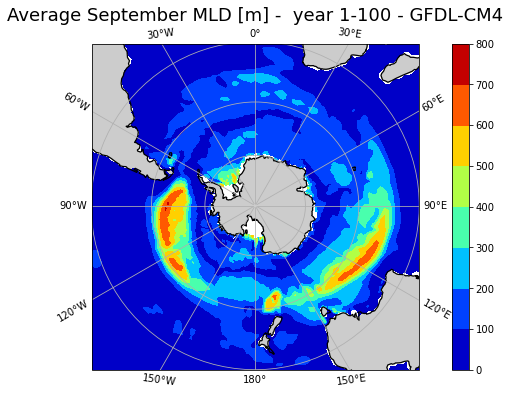

In [23]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=0, color='0.8')
ax.add_feature(cfeature.COASTLINE, linewidth=1.25)

gl = ax.gridlines(
    xlocs = np.arange(-180,180,30), 
    ylocs = np.arange(-90,90,20),
    draw_labels=True, y_inline=False)
# gl.top_labels = False

im = ax.contourf(da_mld.lon, da_mld.lat, pltmld,transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
plt.colorbar(im)
plt.title('Average September MLD [m] - '+' year '+ str(start_year) + '-' + str(end_year) + ' - ' + model_name, fontsize=18)

In [24]:
client.close()
cluster.close()